<div align="center"> <h2> Nhóm 17 - Lớp IS403.P23 - BÁO CÁO ĐỒ ÁN PHÂN TÍCH DỮ LIỆU KINH DOANH <h2> </div>
<div align="center">

<table>
  <thead>
    <tr>
      <th><div align="center">Họ và tên</div></th>
      <th><div align="center">MSSV</div></th>
    </tr>
  </thead>
  <tbody>
    <tr><td>🌱 Trần Vũ Bão</td><td>22520124</td></tr>
    <tr><td>🌱 Phan Thành Công</td><td>22520170</td></tr>
    <tr><td>🌱 Phan Thị Thủy Hiền</td><td>22520423</td></tr>
    <tr><td>🌱 Nguyễn Đỗ Đức Minh</td><td>22520872</td></tr>
  </tbody>
</table>
</div>

# Dự đoán giá bitcoin sử dụng mô hình GRU

In [2]:
# Import các thư viện cần thiết
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

# Thư viện cho machine learning
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Thư viện cho deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Thư viện cho visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

print("Đã import thành công các thư viện!")
print(f"TensorFlow version: {tf.__version__}")

Đã import thành công các thư viện!
TensorFlow version: 2.19.0


## 1. Đọc và khám phá dữ liệu

Trong phần này, chúng ta sẽ tải dataset Bitcoin và thực hiện phân tích khám phá dữ liệu (EDA) để hiểu rõ hơn về đặc điểm của dữ liệu.

In [3]:
# Đọc dữ liệu Bitcoin
data_path = 'bitcoin_price_yahoo_finance.csv'
df = pd.read_csv(data_path)

print("Thông tin cơ bản về dataset:")
print(f"Kích thước dataset: {df.shape}")
print(f"Khoảng thời gian: {df['Date'].min()} đến {df['Date'].max()}")
print(f"Các cột: {list(df.columns)}")

# Hiển thị 5 dòng đầu
print("\n5 dòng đầu tiên:")
df.head()

Thông tin cơ bản về dataset:
Kích thước dataset: (2676, 7)
Khoảng thời gian: 2018-01-01 đến 2025-04-29
Các cột: ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

5 dòng đầu tiên:


,Date,Adj Close,Close,High,Low,Open,Volume
0,2018-01-01,13657.200195,13657.200195,14112.200195,13154.700195,14112.200195,10291200000
1,2018-01-02,14982.099609,14982.099609,15444.599609,13163.599609,13625.000000,16846600192
2,2018-01-03,15201.000000,15201.000000,15572.799805,14844.500000,14978.200195,16871900160
3,2018-01-04,15599.200195,15599.200195,15739.700195,14522.200195,15270.700195,21783199744
4,2018-01-05,17429.500000,17429.500000,17705.199219,15202.799805,15477.200195,23840899072


In [4]:
# Kiểm tra thông tin chi tiết
print("Thông tin chi tiết về dataset:")
print(df.info())

print("\nThống kê mô tả:")
df.describe()

Thông tin chi tiết về dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2676 entries, 0 to 2675
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2676 non-null   object 
 1   Adj Close  2676 non-null   float64
 2   Close      2676 non-null   float64
 3   High       2676 non-null   float64
 4   Low        2676 non-null   float64
 5   Open       2676 non-null   float64
 6   Volume     2676 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 146.5+ KB
None

Thống kê mô tả:


,Adj Close,Close,High,Low,Open,Volume
count,2676.000000,2676.000000,2676.000000,2676.000000,2676.000000,2.676000e+03
mean,30911.611075,30911.611075,31555.799526,30174.365559,30883.254133,2.763285e+10
std,25349.645976,25349.645976,25855.937021,24768.714835,25323.647394,2.004455e+10
min,3236.761719,3236.761719,3275.377930,3191.303467,3236.274658,2.923670e+09
25%,9192.341309,9192.341309,9339.087646,9013.514404,9186.810791,1.436387e+10
50%,23651.378906,23651.378906,24124.528320,23162.128906,23634.151367,2.445092e+10
75%,46404.744141,46404.744141,47402.925781,45128.060547,46365.260742,3.615642e+10
max,106146.265625,106146.265625,109114.882812,105291.734375,106147.296875,3.509679e+11


In [5]:
# Kiểm tra missing values
print("Kiểm tra missing values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "Không có missing values!")

# Chuyển đổi cột Date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

print(f"\nDữ liệu từ {df['Date'].min().strftime('%Y-%m-%d')} đến {df['Date'].max().strftime('%Y-%m-%d')}")
print(f"Tổng cộng {len(df)} ngày giao dịch")

Kiểm tra missing values:
Không có missing values!

Dữ liệu từ 2018-01-01 đến 2025-04-29
Tổng cộng 2676 ngày giao dịch


## 2. Trực quan hóa dữ liệu

Việc trực quan hóa dữ liệu giúp chúng ta hiểu rõ xu hướng và pattern của giá Bitcoin qua thời gian.

In [6]:
# Biểu đồ xu hướng giá Close
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df['Date'], 
    y=df['Close'],
    mode='lines',
    name='Giá đóng cửa',
    line=dict(color='#1f77b4', width=2)
))

fig.update_layout(
    title='Xu hướng giá Bitcoin theo thời gian',
    xaxis_title='Thời gian',
    yaxis_title='Giá (USD)',
    template='plotly_white',
    height=500
)

fig.show()

print(f"Giá cao nhất: ${df['Close'].max():,.2f} vào {df.loc[df['Close'].idxmax(), 'Date'].strftime('%Y-%m-%d')}")
print(f"Giá thấp nhất: ${df['Close'].min():,.2f} vào {df.loc[df['Close'].idxmin(), 'Date'].strftime('%Y-%m-%d')}")

Giá cao nhất: $106,146.27 vào 2025-01-21
Giá thấp nhất: $3,236.76 vào 2018-12-15


In [7]:
# Biểu đồ volume giao dịch
fig_volume = go.Figure()
fig_volume.add_trace(go.Scatter(
    x=df['Date'], 
    y=df['Volume'],
    mode='lines',
    name='Volume',
    line=dict(color='orange', width=1.5)
))

fig_volume.update_layout(
    title='Khối lượng giao dịch Bitcoin',
    xaxis_title='Thời gian',
    yaxis_title='Volume',
    template='plotly_white',
    height=400
)

fig_volume.show()

# Biểu đồ OHLC
fig_ohlc = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                        subplot_titles=('Giá OHLC', 'Volume'),
                        vertical_spacing=0.1)

# OHLC chart
fig_ohlc.add_trace(go.Candlestick(
    x=df['Date'][-100:],  # Chỉ hiển thị 100 ngày gần nhất
    open=df['Open'][-100:],
    high=df['High'][-100:],
    low=df['Low'][-100:],
    close=df['Close'][-100:],
    name='OHLC'
), row=1, col=1)

# Volume
fig_ohlc.add_trace(go.Bar(
    x=df['Date'][-100:],
    y=df['Volume'][-100:],
    name='Volume',
    marker_color='rgba(158,202,225,0.8)'
), row=2, col=1)

fig_ohlc.update_layout(
    title='Biểu đồ nến và Volume (100 ngày gần nhất)',
    template='plotly_white',
    height=600
)

fig_ohlc.show()

## 3. Tiền xử lý dữ liệu

Trước khi đưa vào mô hình GRU, chúng ta cần chuẩn bị dữ liệu theo định dạng phù hợp cho time series prediction.

Shape của dữ liệu: (2676, 1)
Đã normalize dữ liệu về khoảng [0, 1]
Giá trị min sau normalize: 0.000000
Giá trị max sau normalize: 1.000000


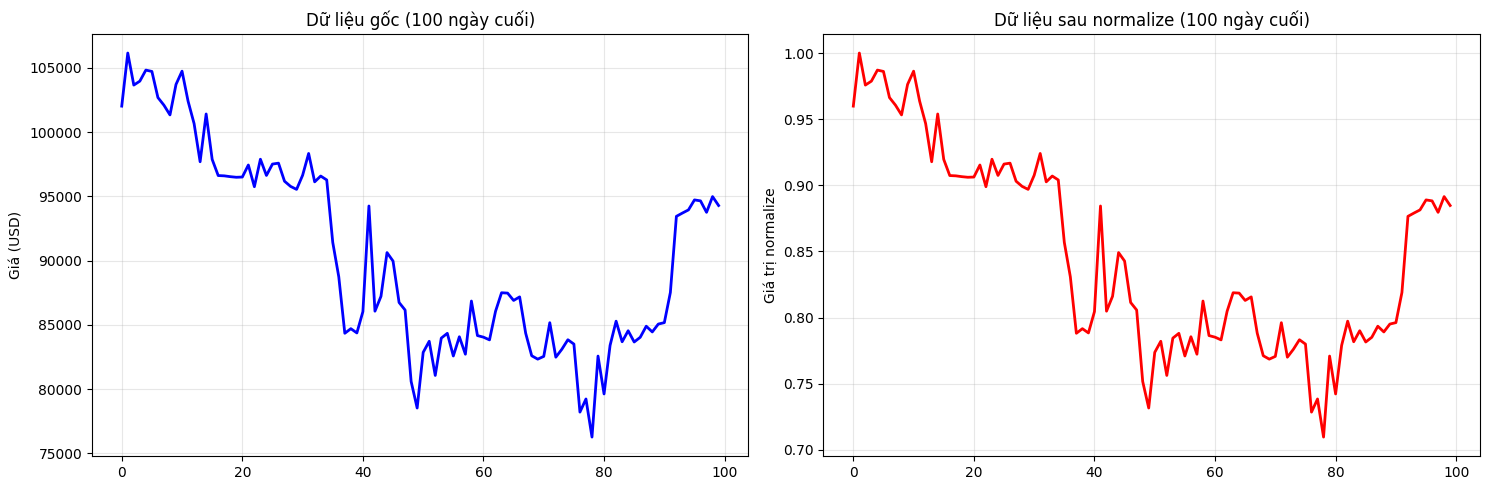

In [8]:
# Chọn feature chính để dự báo (giá Close)
data = df[['Close']].values
print(f"Shape của dữ liệu: {data.shape}")

# Normalize dữ liệu bằng MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

print("Đã normalize dữ liệu về khoảng [0, 1]")
print(f"Giá trị min sau normalize: {scaled_data.min():.6f}")
print(f"Giá trị max sau normalize: {scaled_data.max():.6f}")

# Hiển thị so sánh trước và sau normalize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(data[-100:], color='blue', linewidth=2)
ax1.set_title('Dữ liệu gốc (100 ngày cuối)')
ax1.set_ylabel('Giá (USD)')
ax1.grid(True, alpha=0.3)

ax2.plot(scaled_data[-100:], color='red', linewidth=2)
ax2.set_title('Dữ liệu sau normalize (100 ngày cuối)')
ax2.set_ylabel('Giá trị normalize')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Tổng số điểm dữ liệu: 2676
Dữ liệu train: 2140 điểm (80.0%)
Dữ liệu test: 536 điểm (20.0%)


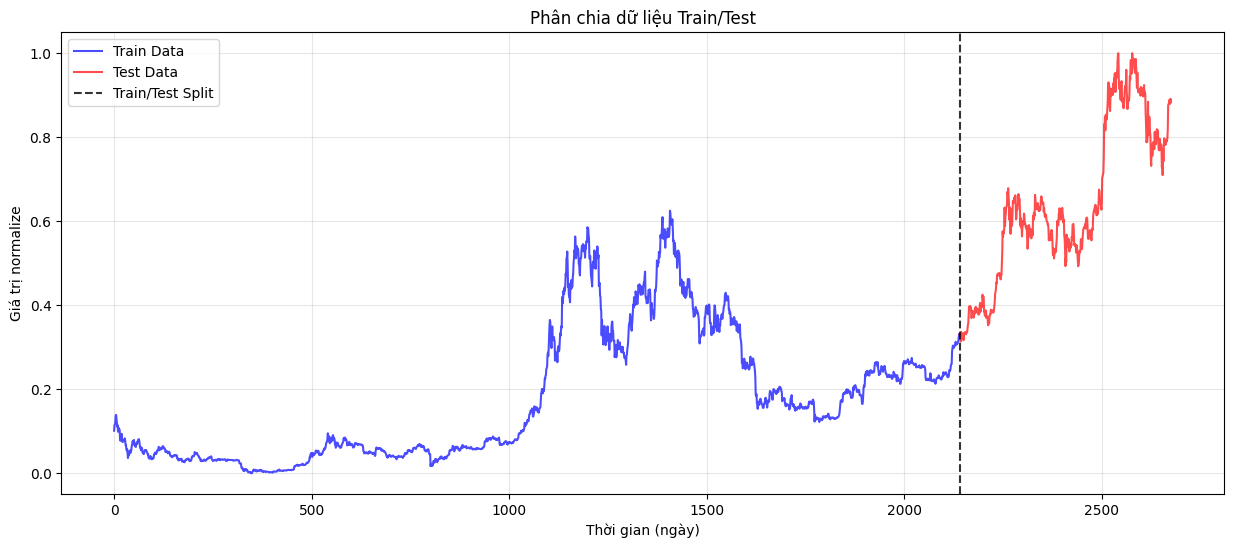

In [9]:
# Chia dữ liệu train/test (80% train, 20% test)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

print(f"Tổng số điểm dữ liệu: {len(scaled_data)}")
print(f"Dữ liệu train: {len(train_data)} điểm ({len(train_data)/len(scaled_data)*100:.1f}%)")
print(f"Dữ liệu test: {len(test_data)} điểm ({len(test_data)/len(scaled_data)*100:.1f}%)")

# Visualize việc chia dữ liệu
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(range(len(train_data)), train_data, label='Train Data', color='blue', alpha=0.7)
ax.plot(range(len(train_data), len(scaled_data)), test_data, label='Test Data', color='red', alpha=0.7)
ax.axvline(x=len(train_data), color='black', linestyle='--', alpha=0.8, label='Train/Test Split')
ax.set_title('Phân chia dữ liệu Train/Test')
ax.set_xlabel('Thời gian (ngày)')
ax.set_ylabel('Giá trị normalize')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

In [10]:
# Tạo time series data với time steps
time_steps = 15  # Sử dụng 15 ngày trước để dự báo ngày tiếp theo

def create_time_series_data(data, time_steps):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Tạo dữ liệu train
X_train, y_train = create_time_series_data(train_data, time_steps)

# Tạo dữ liệu test (sử dụng toàn bộ scaled_data để có đủ context)
X_test, y_test = create_time_series_data(scaled_data[train_size-time_steps:], time_steps)

print(f"Shape của dữ liệu train:")
print(f"   X_train: {X_train.shape} (samples, time_steps)")
print(f"   y_train: {y_train.shape}")
print(f"Shape của dữ liệu test:")
print(f"   X_test: {X_test.shape} (samples, time_steps)")
print(f"   y_test: {y_test.shape}")

# Reshape cho GRU (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"\nShape sau khi reshape cho GRU:")
print(f"   X_train: {X_train.shape} (samples, time_steps, features)")
print(f"   X_test: {X_test.shape} (samples, time_steps, features)")

Shape của dữ liệu train:
   X_train: (2125, 15) (samples, time_steps)
   y_train: (2125,)
Shape của dữ liệu test:
   X_test: (536, 15) (samples, time_steps)
   y_test: (536,)

Shape sau khi reshape cho GRU:
   X_train: (2125, 15, 1) (samples, time_steps, features)
   X_test: (536, 15, 1) (samples, time_steps, features)


## 4. Xây dựng mô hình GRU

Mô hình GRU (Gated Recurrent Unit) là một biến thể của RNN với cơ chế cổng (gate) giúp mô hình học được các dependency dài hạn mà vẫn tránh được vấn đề vanishing gradient. So với LSTM, GRU có cấu trúc đơn giản hơn nhưng vẫn đạt hiệu suất tương đương.

In [11]:
# Xây dựng mô hình GRU
def build_gru_model(input_shape):
    model = Sequential([
        # Layer GRU đầu tiên
        GRU(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        
        # Layer GRU thứ hai
        GRU(50, return_sequences=True),
        Dropout(0.2),
        
        # Layer GRU thứ ba
        GRU(50, return_sequences=False),
        Dropout(0.2),
        
        # Dense layer output
        Dense(1)
    ])
    
    return model

# Tạo mô hình
model = build_gru_model((time_steps, 1))

# Compile mô hình
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

# Hiển thị kiến trúc mô hình
print("Kiến trúc mô hình GRU:")
model.summary()

# Tính số lượng parameters
total_params = model.count_params()
print(f"\nTổng số parameters: {total_params:,}")

Kiến trúc mô hình GRU:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 15, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 15, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,601 (150.79 KB)

 Trainable params: 38,601 (150.79 KB)

 Non-trainable params: 0 (0.00 B)


Tổng số parameters: 38,601


In [12]:
# Thiết lập callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

print("Bắt đầu training mô hình GRU...")
print(f"Epochs: 100")
print(f"Batch size: 32")
print(f"Validation split: 20%")
print("="*50)

# Training mô hình
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

print("\nHoàn thành training!")

Bắt đầu training mô hình GRU...
Epochs: 100
Batch size: 32
Validation split: 20%
Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0116 - mae: 0.0710 - val_loss: 1.4839e-04 - val_mae: 0.0087 - learning_rate: 0.0010
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011 - mae: 0.0213 - val_loss: 4.3059e-04 - val_mae: 0.0189 - learning_rate: 0.0010
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012 - mae: 0.0222 - val_loss: 1.4345e-04 - val_mae: 0.0088 - learning_rate: 0.0010
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.7563e-04 - mae: 0.0175 - val_loss: 1.0974e-04 - val_mae: 0.0071 - learning_rate: 0.0010
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.5345e-04 - mae: 0.0179 - val_loss: 1.0990e-04 - val_mae: 0.0072 - learning_rate: 0.0010
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.5662e-04 - mae: 0.0180
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
54/54 ━━━━━━━━━━━━━━

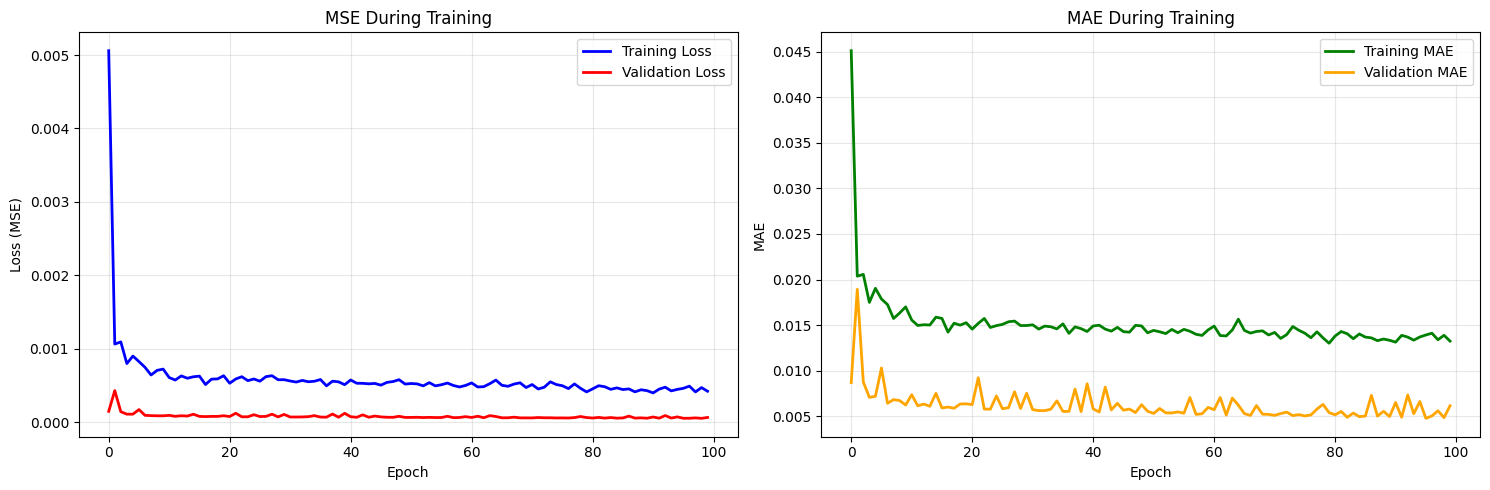

Số epochs đã train: 100
Final training loss: 0.000422
Final validation loss: 0.000065


In [13]:
# Visualize training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
ax1.plot(history.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
ax1.set_title('MSE During Training')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# MAE
ax2.plot(history.history['mae'], label='Training MAE', color='green', linewidth=2)
ax2.plot(history.history['val_mae'], label='Validation MAE', color='orange', linewidth=2)
ax2.set_title('MAE During Training')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# In ra số epoch thực tế đã train
epochs_trained = len(history.history['loss'])
print(f"Số epochs đã train: {epochs_trained}")
print(f"Final training loss: {history.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.6f}")

## 5. Đánh giá mô hình

Sau khi training, chúng ta sẽ đánh giá hiệu suất của mô hình GRU trên cả tập train và test để kiểm tra khả năng dự báo.

In [14]:
# Dự báo trên tập train và test
print("Đang thực hiện dự báo...")
train_predictions = model.predict(X_train, verbose=0)
test_predictions = model.predict(X_test, verbose=0)

# Inverse transform để có được giá trị thực
train_predictions = scaler.inverse_transform(train_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

test_predictions = scaler.inverse_transform(test_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

print("Đã hoàn thành dự báo và inverse transform!")
print(f"Shape train predictions: {train_predictions.shape}")
print(f"Shape test predictions: {test_predictions.shape}")

Đang thực hiện dự báo...
Đã hoàn thành dự báo và inverse transform!
Shape train predictions: (2125, 1)
Shape test predictions: (536, 1)


In [15]:
# Tính toán các metrics đánh giá
def calculate_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Tính MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\nKết quả đánh giá trên {dataset_name}:")
    print(f"   RMSE: {rmse:,.2f}")
    print(f"   MAE: {mae:,.2f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   R² Score: {r2:.4f} ({r2*100:.2f}%)")
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2
    }

# Đánh giá trên tập train
train_metrics = calculate_metrics(y_train_actual, train_predictions, "Training Set")

# Đánh giá trên tập test
test_metrics = calculate_metrics(y_test_actual, test_predictions, "Test Set")

# So sánh performance
print(f"\nSo sánh hiệu suất:")
print(f"   Train R²: {train_metrics['R2']:.4f} vs Test R²: {test_metrics['R2']:.4f}")
print(f"   Độ chênh lệch R²: {abs(train_metrics['R2'] - test_metrics['R2']):.4f}")

if abs(train_metrics['R2'] - test_metrics['R2']) > 0.1:
    print("   Có dấu hiệu overfitting (chênh lệch R² > 0.1)")
else:
    print("   Mô hình có độ ổn định tốt")


Kết quả đánh giá trên Training Set:
   RMSE: 1,180.61
   MAE: 718.62
   MAPE: 3.71%
   R² Score: 0.9945 (99.45%)

Kết quả đánh giá trên Test Set:
   RMSE: 2,808.44
   MAE: 2,085.24
   MAPE: 2.85%
   R² Score: 0.9780 (97.80%)

So sánh hiệu suất:
   Train R²: 0.9945 vs Test R²: 0.9780
   Độ chênh lệch R²: 0.0166
   Mô hình có độ ổn định tốt


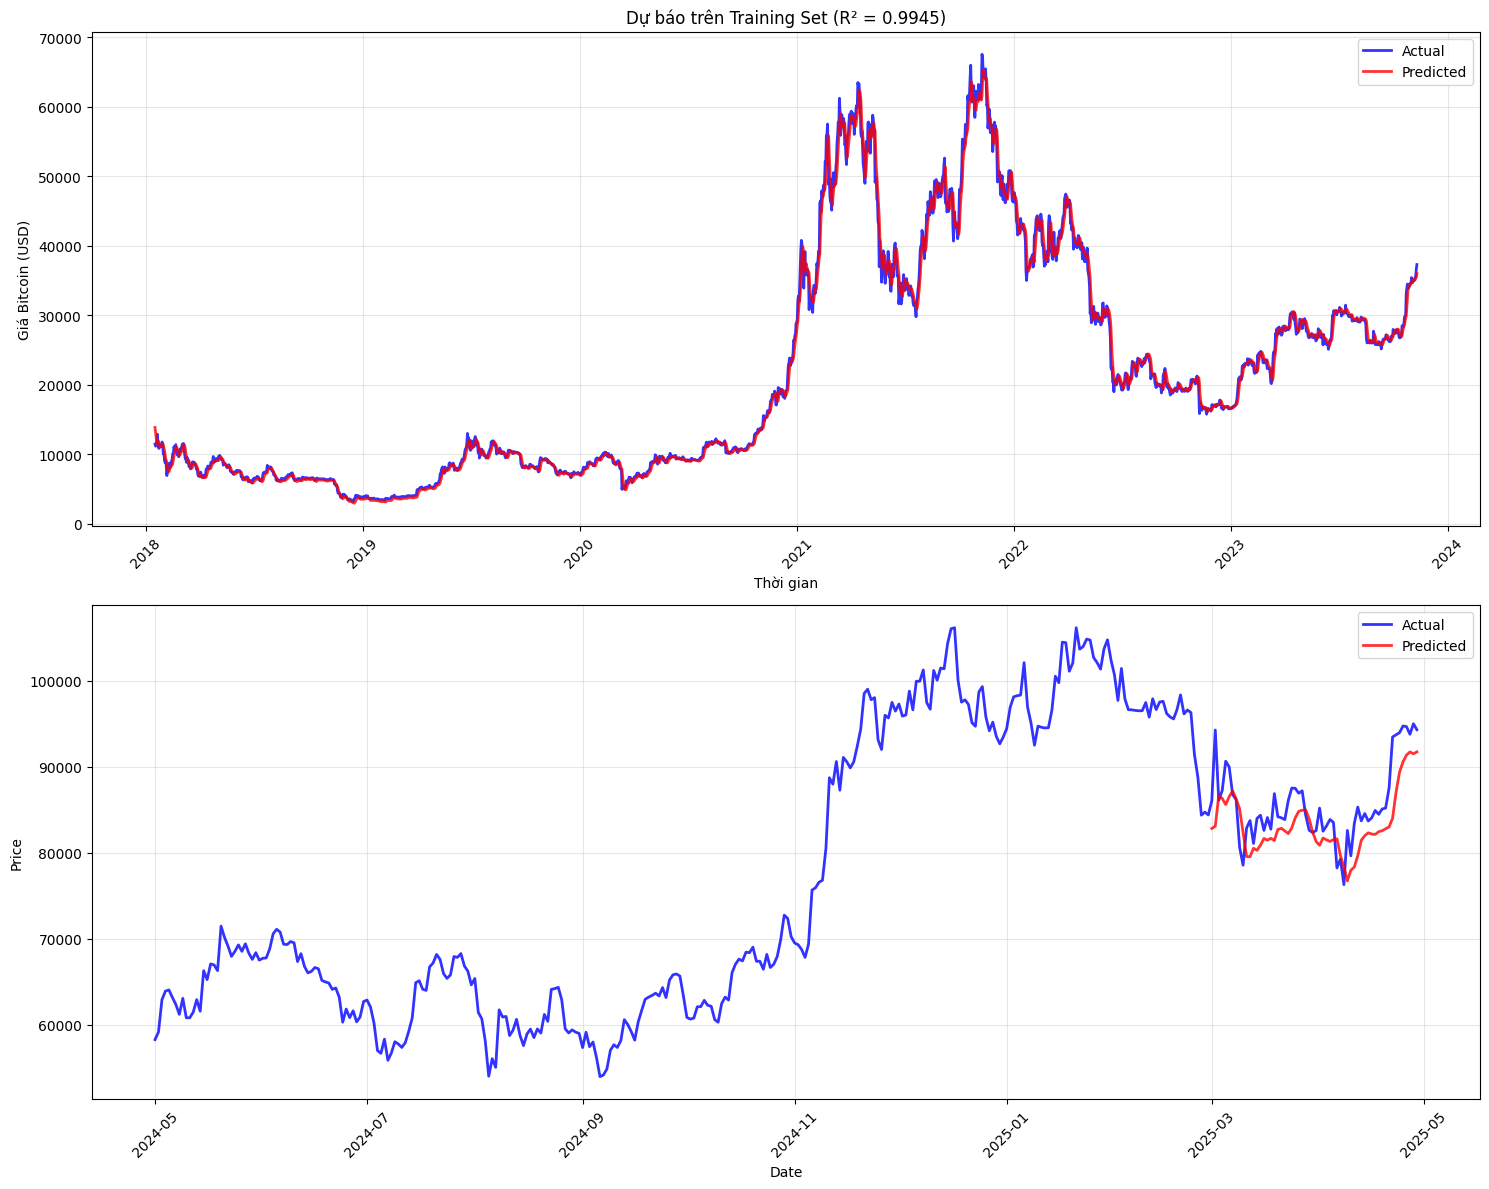

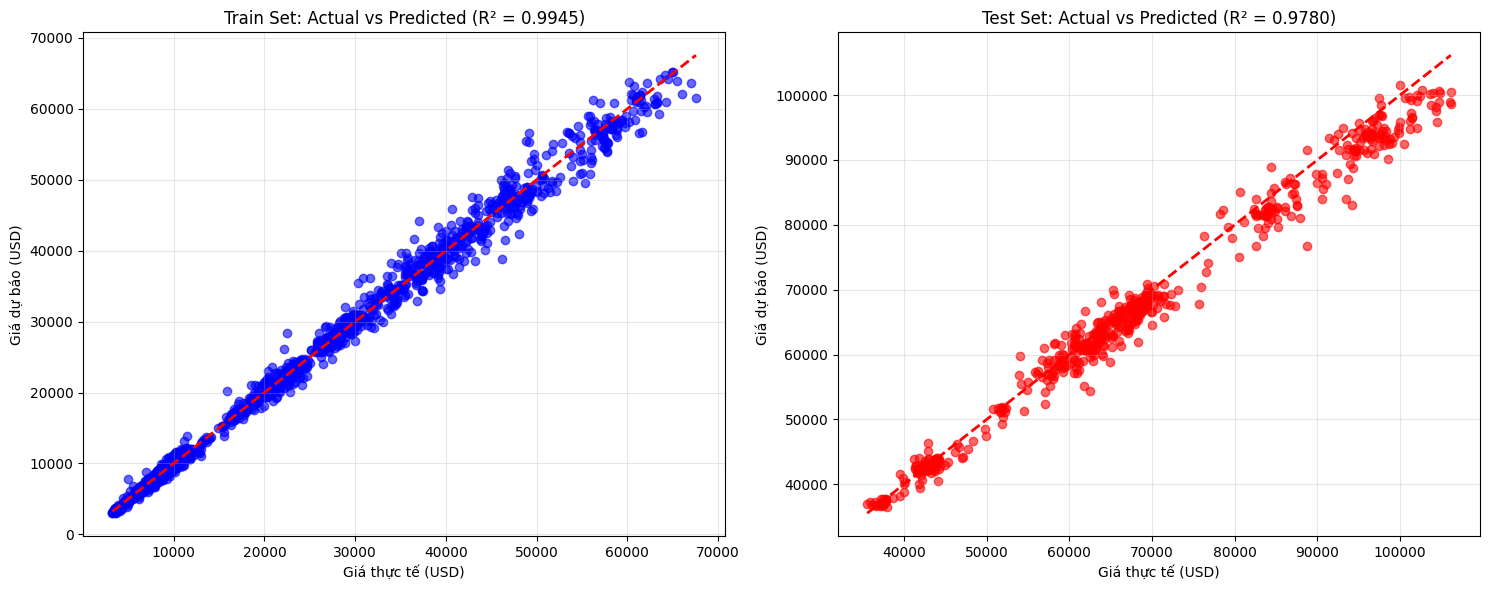

In [ ]:
# Visualization kết quả dự báo
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Create date ranges for train and test predictions
# Train dates (excluding first time_steps days since we need lookback)
train_dates = df['Date'][time_steps:train_size]

# Test dates (starting from train_size)
test_dates = df['Date'][train_size:]

# Plot train predictions with dates
ax1.plot(train_dates, y_train_actual, label='Actual', color='blue', linewidth=2, alpha=0.8)
ax1.plot(train_dates, train_predictions, label='Predicted', color='red', linewidth=2, alpha=0.8)
ax1.set_title(f'Dự báo trên Training Set (R² = {train_metrics["R2"]:.4f})')
ax1.set_xlabel('Thời gian')
ax1.set_ylabel('Giá Bitcoin (USD)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Filter test data from March 2025 onward for predictions only
march_2025 = pd.to_datetime('2025-03-01')

# Get index for March 2025 in test data
march_2025_idx = None
for i, date in enumerate(test_dates):
    if march_2025_idx is None and date >= march_2025:
        march_2025_idx = i
        break

# If we don't have March 2025 data, show all available data for predictions
if march_2025_idx is None:
    march_2025_idx = len(test_dates)

# Plot ALL actual test data (blue line)
ax2.plot(test_dates, y_test_actual, label='Actual', color='blue', linewidth=2, alpha=0.8)

# Plot predicted data only from March 2025 onward (red line)
if march_2025_idx < len(test_dates):
    pred_dates = test_dates[march_2025_idx:]
    pred_values = test_predictions[march_2025_idx:]
    ax2.plot(pred_dates, pred_values, label='Predicted', color='red', linewidth=2, alpha=0.8)
else:
    # Fallback: show all test predictions if March 2025 not found
    ax2.plot(test_dates, test_predictions, label='Predicted', color='red', linewidth=2, alpha=0.8)

ax2.set_title(f'Dự báo trên Test Set - Toàn bộ dữ liệu thực tế vs Dự báo từ March 2025 (R² = {test_metrics["R2"]:.4f})')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Scatter plot để xem correlation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Train set scatter
ax1.scatter(y_train_actual, train_predictions, alpha=0.6, color='blue')
ax1.plot([y_train_actual.min(), y_train_actual.max()], 
		 [y_train_actual.min(), y_train_actual.max()], 'r--', lw=2)
ax1.set_xlabel('Giá thực tế (USD)')
ax1.set_ylabel('Giá dự báo (USD)')
ax1.set_title(f'Train Set: Actual vs Predicted (R² = {train_metrics["R2"]:.4f})')
ax1.grid(True, alpha=0.3)

# Test set scatter
ax2.scatter(y_test_actual, test_predictions, alpha=0.6, color='red')
ax2.plot([y_test_actual.min(), y_test_actual.max()], 
		 [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
ax2.set_xlabel('Giá thực tế (USD)')
ax2.set_ylabel('Giá dự báo (USD)')
ax2.set_title(f'Test Set: Actual vs Predicted (R² = {test_metrics["R2"]:.4f})')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 🔮 6. Dự báo giá Bitcoin trong tương lai

Sử dụng mô hình GRU đã train để dự báo giá Bitcoin trong 30 ngày tới.

In [17]:
# Dự báo giá Bitcoin trong 30 ngày tới
def predict_future_prices(model, last_sequence, days_ahead=30):
    """
    Dự báo giá trong tương lai
    """
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(days_ahead):
        # Dự báo ngày tiếp theo
        next_pred = model.predict(current_sequence.reshape(1, time_steps, 1), verbose=0)
        future_predictions.append(next_pred[0, 0])
        
        # Cập nhật sequence (loại bỏ giá trị cũ nhất, thêm dự báo mới)
        current_sequence = np.append(current_sequence[1:], next_pred[0, 0])
    
    return np.array(future_predictions)

# Lấy sequence cuối cùng từ dữ liệu
last_sequence = scaled_data[-time_steps:].flatten()

print("Dự báo giá Bitcoin cho 30 ngày tới...")
future_scaled = predict_future_prices(model, last_sequence, days_ahead=30)

# Inverse transform để có giá thực
future_prices = scaler.inverse_transform(future_scaled.reshape(-1, 1)).flatten()

# Tạo dates cho future predictions
last_date = df['Date'].iloc[-1]
future_dates = [last_date + pd.Timedelta(days=i+1) for i in range(30)]

start_date = future_dates[0].strftime('%Y-%m-%d')
end_date = future_dates[-1].strftime('%Y-%m-%d')

print(f"Dự báo từ {start_date} (ngày thứ 1) đến {end_date} (ngày thứ 30)")
print(f"💰 Giá mới nhất: ${df['Close'].iloc[-1]:,.2f}")
print(f"💰 Giá dự báo ngày thứ 1: ${future_prices[0]:,.2f}")
print(f"💰 Giá dự báo ngày thứ 30: ${future_prices[-1]:,.2f}")
print(f"📈 Thay đổi dự kiến: {((future_prices[-1] - df['Close'].iloc[-1]) / df['Close'].iloc[-1] * 100):+.2f}%")

Dự báo giá Bitcoin cho 30 ngày tới...
Dự báo từ 2025-04-30 (ngày thứ 1) đến 2025-05-29 (ngày thứ 30)
💰 Giá mới nhất: $94,284.79
💰 Giá dự báo ngày thứ 1: $91,678.92
💰 Giá dự báo ngày thứ 30: $68,167.41
📈 Thay đổi dự kiến: -27.70%


In [ ]:
# Visualization dự báo tương lai
fig = go.Figure()

# Historical data (15 ngày gần nhất)
historical_data = df.tail(15)
fig.add_trace(go.Scatter(
    x=historical_data['Date'],
    y=historical_data['Close'],
    mode='lines',
    name='Last 15 days of close price',
    line=dict(color='blue', width=2)
))

# Future predictions
fig.add_trace(go.Scatter(
    x=future_dates,
    y=future_prices,
    mode='lines+markers',
    name='Predicted next 30 days close price',
    line=dict(color='red', width=2, dash='dash'),
    marker=dict(size=4)
))

# Điểm nối giữa historical và future
fig.add_trace(go.Scatter(
    x=[df['Date'].iloc[-1], future_dates[0]],
    y=[df['Close'].iloc[-1], future_prices[0]],
    mode='lines',
    name='Điểm nối',
    line=dict(color='green', width=3),
    showlegend=False
))

fig.update_layout(
    # title='Dự báo giá Bitcoin: Lịch sử vs Tương lai (30 ngày)',
    xaxis_title='Date',
    yaxis_title='Price',
    template='plotly_white',
    height=600,
    hovermode='x unified',
    # Add margins around the plot area
    margin=dict(l=80, r=80, t=100, b=80),
    # Add black border with padding
    plot_bgcolor='white',
    paper_bgcolor='white',
    # Position legend on the right side of the chart
    legend=dict(
        x=0.98,  # Distance from left edge (98% from left, near right side)
        y=0.98,  # Distance from bottom (98% from bottom, near top)
        xanchor='right',  # Anchor to the right side
        yanchor='top',
        bgcolor='rgba(255,255,255,0.8)',  # Semi-transparent white background
        bordercolor='rgba(0,0,0,0.3)',    # Light border
        borderwidth=1
    ),
    xaxis=dict(
        showline=True,
        linewidth=2,
        linecolor='black',
        mirror=True,
        # Add padding around x-axis
        range=[historical_data['Date'].min() - pd.Timedelta(days=5), 
               future_dates[-1] + pd.Timedelta(days=5)]
    ),
    yaxis=dict(
        showline=True,
        linewidth=2,
        linecolor='black',
        mirror=True,
        # Add padding around y-axis (5% above and below the data range)
        range=[min(historical_data['Close'].min(), future_prices.min()) * 0.95,
               max(historical_data['Close'].max(), future_prices.max()) * 1.05]
    )
)

fig.show()

# Tạo bảng dự báo chi tiết cho 10 ngày đầu
print("\n📋 Dự báo chi tiết (10 ngày đầu):")
forecast_df = pd.DataFrame({
    'Ngày': [date.strftime('%Y-%m-%d') for date in future_dates[:10]],
    'Giá dự báo (USD)': [f"${price:,.2f}" for price in future_prices[:10]],
    'Thay đổi từ hiện tại (%)': [f"{((price - df['Close'].iloc[-1]) / df['Close'].iloc[-1] * 100):+.2f}%" for price in future_prices[:10]]
})

display(forecast_df)


📋 Dự báo chi tiết (10 ngày đầu):


,Ngày,Giá dự báo (USD),Thay đổi từ hiện tại (%)
0,2025-04-30,"$91,678.92",-2.76%
1,2025-05-01,"$90,590.56",-3.92%
2,2025-05-02,"$89,310.45",-5.28%
3,2025-05-03,"$88,060.92",-6.60%
4,2025-05-04,"$86,863.10",-7.87%
5,2025-05-05,"$85,713.62",-9.09%
6,2025-05-06,"$84,610.05",-10.26%
7,2025-05-07,"$83,551.38",-11.38%
8,2025-05-08,"$82,536.70",-12.46%
9,2025-05-09,"$81,563.46",-13.49%


## 7. Phân tích kết quả và kết luận

### Giải thích các metrics đánh giá:

1. **MSE (Mean Squared Error)**: Trung bình bình phương của sai số. Giá trị càng nhỏ càng tốt.
2. **RMSE (Root Mean Squared Error)**: Căn bậc hai của MSE, có cùng đơn vị với dữ liệu gốc.
3. **MAE (Mean Absolute Error)**: Trung bình tuyệt đối của sai số.
4. **MAPE (Mean Absolute Percentage Error)**: Trung bình tỷ lệ phần trăm sai số tuyệt đối.
5. **R² Score**: Hệ số xác định, cho biết mô hình giải thích được bao nhiêu % độ biến thiên của dữ liệu. Giá trị từ 0-1, càng gần 1 càng tốt.

### Phân tích kết quả mô hình GRU:

In [19]:
# Phân tích chi tiết kết quả
print("PHÂN TÍCH CHI TIẾT KẾT QUẢ MÔ HÌNH GRU")
print("="*60)

print(f"\nHiệu suất trên Training Set:")
print(f"   • R² Score: {train_metrics['R2']:.4f} ({train_metrics['R2']*100:.2f}%)")
print(f"   • RMSE: ${train_metrics['RMSE']:,.2f}")
print(f"   • MAE: ${train_metrics['MAE']:,.2f}")

print(f"\nHiệu suất trên Test Set:")
print(f"   • R² Score: {test_metrics['R2']:.4f} ({test_metrics['R2']*100:.2f}%)")
print(f"   • RMSE: ${test_metrics['RMSE']:,.2f}")
print(f"   • MAE: ${test_metrics['MAE']:,.2f}")

# Đánh giá overfitting
r2_diff = abs(train_metrics['R2'] - test_metrics['R2'])
print(f"\nPhân tích Overfitting:")
print(f"   • Chênh lệch R² (Train - Test): {r2_diff:.4f}")

if r2_diff > 0.3:
    overfitting_level = "Nghiêm trọng"
elif r2_diff > 0.1:
    overfitting_level = "Trung bình"
else:
    overfitting_level = "Thấp"

print(f"   • Mức độ overfitting: {overfitting_level}")

# Đánh giá độ chính xác dự báo
if test_metrics['R2'] > 0.8:
    accuracy_level = "Rất tốt"
elif test_metrics['R2'] > 0.6:
    accuracy_level = "Tốt"
elif test_metrics['R2'] > 0.3:
    accuracy_level = "Trung bình"
else:
    accuracy_level = "Kém"

print(f"\nĐánh giá độ chính xác: {accuracy_level}")

# Khuyến nghị
print(f"\nKhuyến nghị:")
if test_metrics['R2'] < 0.5:
    print("   • Mô hình hiện tại chưa đủ tin cậy cho việc dự báo thực tế")
    print("   • Cần cải thiện thêm kiến trúc mô hình hoặc feature engineering")
else:
    print("   • Mô hình có thể sử dụng tham khảo nhưng cần thận trọng")
    print("   • Nên kết hợp với các chỉ báo kỹ thuật khác")

print("   • Theo dõi và cập nhật mô hình thường xuyên")
print("   • Không nên đầu tư dựa hoàn toàn vào dự báo của mô hình")

PHÂN TÍCH CHI TIẾT KẾT QUẢ MÔ HÌNH GRU

Hiệu suất trên Training Set:
   • R² Score: 0.9945 (99.45%)
   • RMSE: $1,180.61
   • MAE: $718.62

Hiệu suất trên Test Set:
   • R² Score: 0.9780 (97.80%)
   • RMSE: $2,808.44
   • MAE: $2,085.24

Phân tích Overfitting:
   • Chênh lệch R² (Train - Test): 0.0166
   • Mức độ overfitting: Thấp

Đánh giá độ chính xác: Rất tốt

Khuyến nghị:
   • Mô hình có thể sử dụng tham khảo nhưng cần thận trọng
   • Nên kết hợp với các chỉ báo kỹ thuật khác
   • Theo dõi và cập nhật mô hình thường xuyên
   • Không nên đầu tư dựa hoàn toàn vào dự báo của mô hình
